# Inspect the dataset
We will use a dataset of plant diease detection which contains 2850 images. It is subset of available dataset on Kaggle, which contains images of approximately (1.7 GB).  

In [1]:
import os

base_dir = 'PlantDiseasesDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with training healthy pictures
train_healthy_dir = os.path.join(train_dir, 'healthy')

#Directory with training unhealthy pictures
train_unhealthy_dir = os.path.join(train_dir, 'unhealthy')

#Directory with validation healthy pictures
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

#Directory with validation unhealthy pictures
validation_unhealthy_dir = os.path.join(validation_dir, 'unhealthy')

In [2]:
train_healthy_fnames = os.listdir(train_healthy_dir)
train_unhealthy_fnames = os.listdir(train_unhealthy_dir)

print(train_healthy_fnames[:10])
print(train_unhealthy_fnames[:10])

['Apple (1).JPG', 'Apple (10).JPG', 'Apple (11).JPG', 'Apple (12).JPG', 'Apple (13).JPG', 'Apple (14).JPG', 'Apple (15).JPG', 'Apple (16).JPG', 'Apple (17).JPG', 'Apple (18).JPG']
['Apple-blackrot (1).JPG', 'Apple-blackrot (10).JPG', 'Apple-blackrot (11).JPG', 'Apple-blackrot (12).JPG', 'Apple-blackrot (13).JPG', 'Apple-blackrot (14).JPG', 'Apple-blackrot (15).JPG', 'Apple-blackrot (16).JPG', 'Apple-blackrot (17).JPG', 'Apple-blackrot (18).JPG']


A look on the dataset by viewing images of the dataset

In [3]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0

Lets display 8 healthy and 8 unhealthy pictures. We can rerun the cell to get a fresh batch every time.

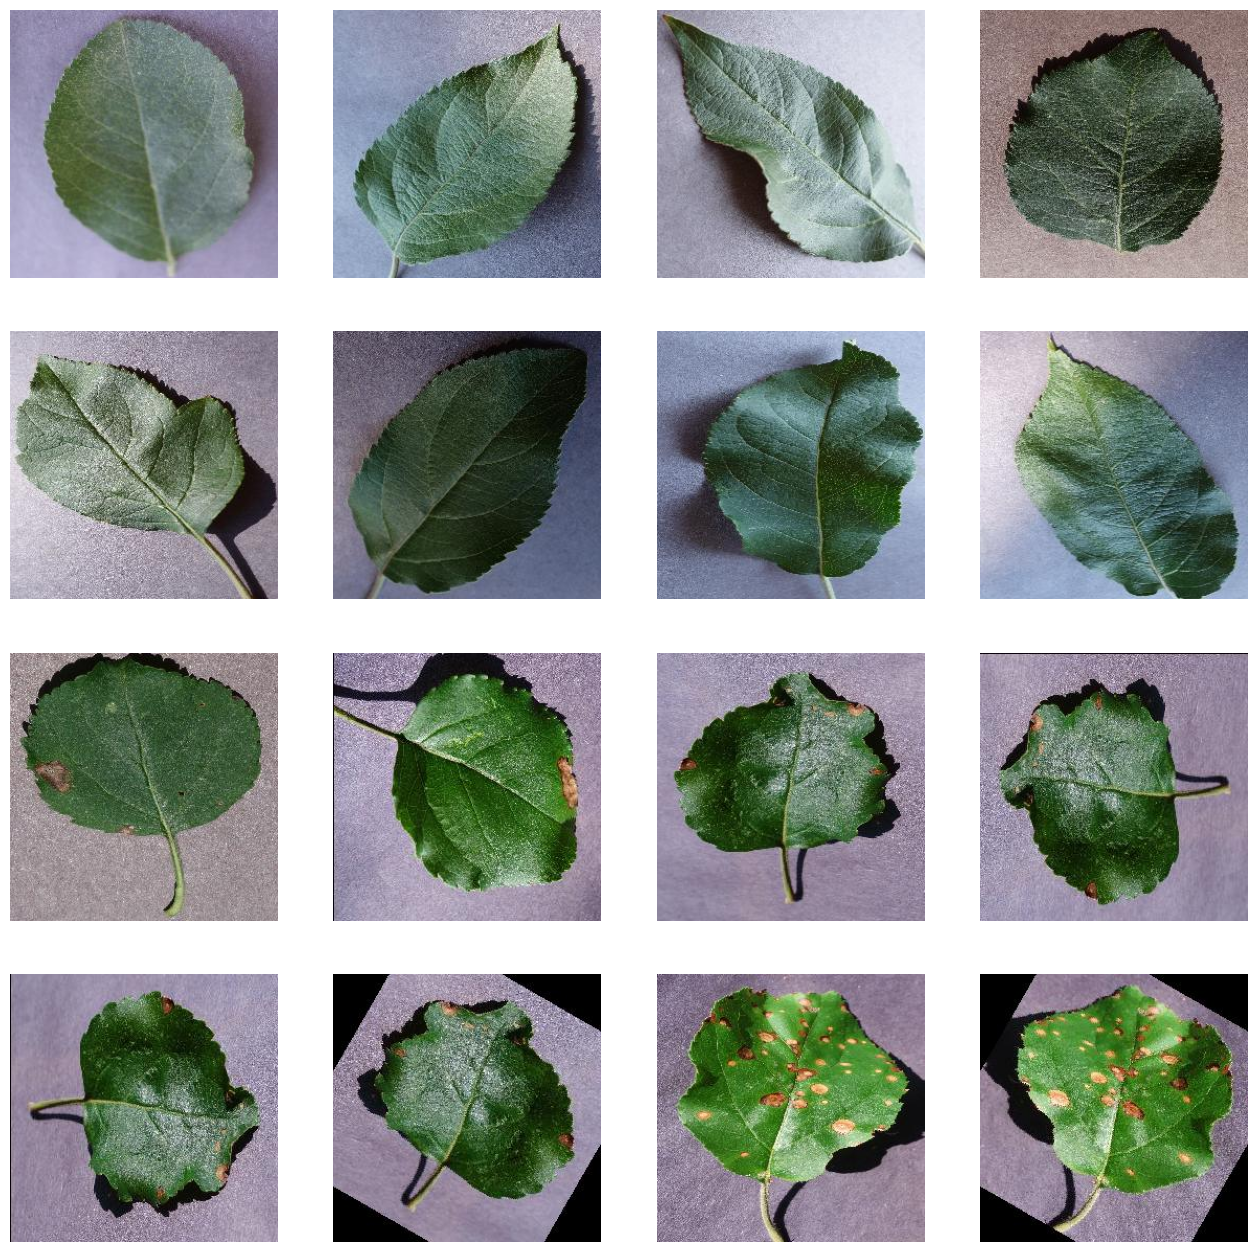

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_healthy_pix = [os.path.join(train_healthy_dir, fname)
                   for fname in train_healthy_fnames[pic_index-8:pic_index]
                   ]

next_unhealthy_pix = [os.path.join(train_unhealthy_dir, fname)
                   for fname in train_unhealthy_fnames[pic_index-8:pic_index]
                   ]

for i, img_path in enumerate(next_healthy_pix+next_unhealthy_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Building a model from scratch and to get to ~78% Accuracy

To train a neural network, handle the images in equal proportions or uniform size. We will choose 150x150 pixels for this. Import Tensorflow for model building and Keras API.  

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

""" 
1024 neuron hidden layers. Only 1 output neuron. 
It will contain a value from 0-1 where 0 for class 'healthy' and 1 for class unhealthy.
Flatten the results to feed into a DNN
"""

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
  

We are defining a Sequential layer, by adding some convolution layers first. Here we put the 150x150 size and 3 for depth color as parameter for input_shape. Then flatten the final result to feed into the densely connected layers.

Since we are solving a binary classification problem, we will need the network with a sigmoid activation. The output of the network will be a single scalar between 0 and 1, encoding the probability the current image is class 1 (as opposed to class 0).

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

Now, we will configure the specifications for model training. We will train our model with binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. Then use an optimizer such as rmsprop optimizer with a learning rate of 0.001. 

In [15]:
model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-3),
                metrics=['accuracy'])

# Data preprocessing
Next step is to set up the data generators that will read pictures in the source folder, convert them to float32 tensors, and feed them (with their labels) to the model. These generators will yield batches of images of size 150x150 and their labels (categorical)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 32,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 1780 images belonging to 2 classes.
Found 1070 images belonging to 2 classes.


# Training

Now we will train on 1,780 images available, for 20 epochs, and monitor the accuracy as well as on the 1,070 images in the validation set. The output for the model training are Loss, Accuracy, Validation Loss and Validation Accuracy. 

In [19]:
history = model.fit(
            train_generator,
            steps_per_epoch=50, 
            epochs=20,
            validation_data=validation_generator,
            validation_steps=25, 
            verbose=2
            )

Epoch 1/20
50/50 - 33s - loss: 0.6085 - accuracy: 0.7009 - val_loss: 0.4956 - val_accuracy: 0.7613 - 33s/epoch - 659ms/step
Epoch 2/20
50/50 - 33s - loss: 0.5306 - accuracy: 0.7519 - val_loss: 0.6294 - val_accuracy: 0.6075 - 33s/epoch - 669ms/step
Epoch 3/20
50/50 - 33s - loss: 0.4992 - accuracy: 0.7418 - val_loss: 0.4221 - val_accuracy: 0.7862 - 33s/epoch - 663ms/step
Epoch 4/20
50/50 - 33s - loss: 0.4774 - accuracy: 0.7676 - val_loss: 0.3984 - val_accuracy: 0.8662 - 33s/epoch - 658ms/step
Epoch 5/20
50/50 - 33s - loss: 0.4235 - accuracy: 0.8054 - val_loss: 0.3101 - val_accuracy: 0.8587 - 33s/epoch - 661ms/step
Epoch 6/20
50/50 - 33s - loss: 0.4226 - accuracy: 0.8048 - val_loss: 0.5280 - val_accuracy: 0.7425 - 33s/epoch - 667ms/step
Epoch 7/20
50/50 - 33s - loss: 0.3830 - accuracy: 0.8256 - val_loss: 0.2895 - val_accuracy: 0.8750 - 33s/epoch - 662ms/step
Epoch 8/20
50/50 - 33s - loss: 0.3534 - accuracy: 0.8401 - val_loss: 0.2479 - val_accuracy: 0.9025 - 33s/epoch - 655ms/step
Epoch 9/

# Model Prediction
We will plot the training/validation accuracy and loss as collected during training

In [20]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

plt.show()

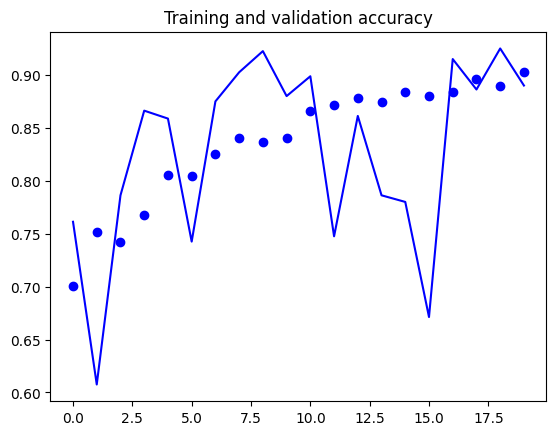

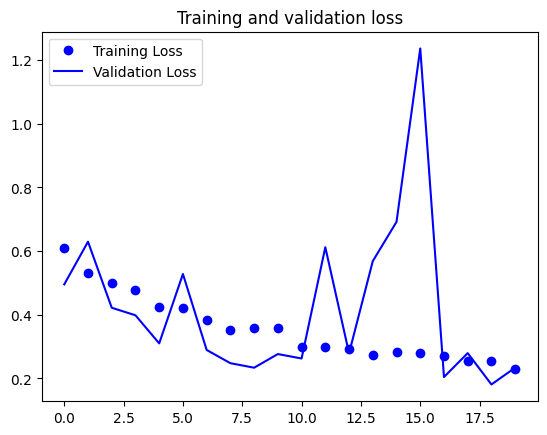

In [21]:
plot_loss_acc(history)

1/1 [==============================] - 0s 66ms/step
This image is 100.00% healthy and 0.00% unhealthy.


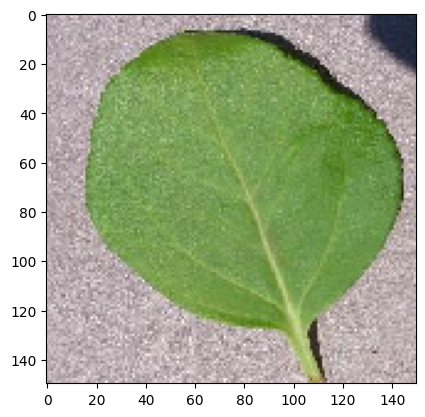

In [33]:
from tensorflow import keras
img = keras.utils.load_img(
    "C:\\Users\\Shashwat\\Downloads\\download (1).jpg", target_size=(150,150)
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% healthy and {100 * score:.2f}% unhealthy.")

In [38]:
model.save('disease_model.keras')